In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init

In [2]:
import mplhep as hep
import mplhep.label as label_base
plt.style.use(hep.style.CMS)

In [3]:
f_rnd = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5")
f_3prong = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5")
f_purebkg = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_background.h5")

In [4]:
f_BB1 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5")
f_BB2 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB2.h5")
f_BB3 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB3.h5")

In [179]:
dt = f_BB1.values

In [180]:
dt_rnd = f_rnd.values

In [181]:
correct = (dt[:,3]>0) &(dt[:,19]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]
    
for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])
        
        
correct = (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
dt = dt[correct]

In [182]:

rnd_idx = dt_rnd[:,-1]
print(rnd_idx[:30])

correct = (dt_rnd[:,3]>0) &(dt_rnd[:,19]>0)
dt_rnd = dt_rnd[correct]
for i in range(13,19):
    dt_rnd[:,i] = dt_rnd[:,i]/dt_rnd[:,3]
    
for i in range(29,35):
    dt_rnd[:,i] = dt_rnd[:,i]/(dt_rnd[:,19])
        
        
correct = (dt_rnd[:,29]>=0) &(dt_rnd[:,29]<=1)&(dt_rnd[:,30]>=0) &(dt_rnd[:,30]<=1)&(dt_rnd[:,31]>=0) &(dt_rnd[:,31]<=1)&(dt_rnd[:,32]>=0) &(dt_rnd[:,32]<=1)&(dt_rnd[:,33]>=0) &(dt_rnd[:,33]<=1)&(dt_rnd[:,34]>=-0.01) &(dt_rnd[:,34]<=1)
dt_rnd = dt_rnd[correct]

rnd_idx = dt_rnd[:,-1]
print(rnd_idx[:30])
print(len(rnd_idx))
correct = np.where(rnd_idx == 0)[0]
print(len(correct))
dt_bkg = dt_rnd[correct]

[0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0.]
1013459
938331


In [183]:
bb_mass = dt[:,0]
bb_j1trim = dt[:,3] * dt[:,13]
bb_j2trim = dt[:,19] * dt[:,29]

bb_j1sdb1 = dt[:,3] * dt[:,16]
bb_j2sdb1 = dt[:,19] * dt[:,32]

bb_j1raw = dt[:,3]

In [184]:
bkg_mass = dt_bkg[:,0]
bkg_j1trim = dt_bkg[:,3] * dt_bkg[:,13]
bkg_j2trim = dt_bkg[:,19] * dt_bkg[:,29]

bkg_j1sdb1 = dt_bkg[:,3] * dt_bkg[:,16]
bkg_j2sdb1 = dt_bkg[:,19] * dt_bkg[:,32]

bkg_j1raw = dt_bkg[:,3]

In [185]:
#dt_rnd = f_rnd.values
#rnd_idx = dt_rnd[:,-1]

In [186]:
#improve purity of trainig by only selecting properly reconstructed jets 

# APPLY PRESELECTION BEFORE DOING THE FIT TO THE LDA

In [187]:
def generate_X(whichsample):
    #bkgloss_0 = np.load(f'../data_strings/bkgae_rndbkg_loss_{whichsample}.npy')
    bkgloss_1 = np.load(f'../data_strings/bkgae_purebkg_withmass_turnonselection_Huberloss_beta1_WAICloss_{whichsample}.npy')
    sigaeloss_0 = np.load(f'../data_strings/sigae_2prong_5tausMasRatioNoRawMass_turnonselection_MSELoss_beta1_z6f8_Justloss_{whichsample}.npy')
    #sigaeloss_1 = np.load(f'../data_strings/sigae_3prong_withmassNORAWJETMASS_turnonselection_MSEloss_beta1_WAICloss_{whichsample}.npy')
    sigaeloss_1 = np.load(f'../data_strings/sigae_3prong_withmassNORAWJETMASS_turnonselection_MSEloss_beta0p1_WAICloss_{whichsample}.npy')
    bkgloss_1[bkgloss_1 > 1e6 ] = 1e6
    sigaeloss_0[sigaeloss_0 > 1e6 ] = 1e6
    sigaeloss_1[sigaeloss_1 > 1e6 ] = 1e6
    
    #print(np.max(bkgloss_0))
    print(np.max(bkgloss_1))
    print(np.max(sigaeloss_0))
    print(np.max(sigaeloss_1))
    
    print(len(bkgloss_1))
    
    
    return np.column_stack((bkgloss_1,sigaeloss_0,sigaeloss_1))

In [190]:
BB1 = generate_X('bb1')

1000000.0
13511.104
20021.203
914617


In [191]:
BKG = generate_X('rndbkg')

1000000.0
15482.961
22914.14
938331


(0.0, 200.0)

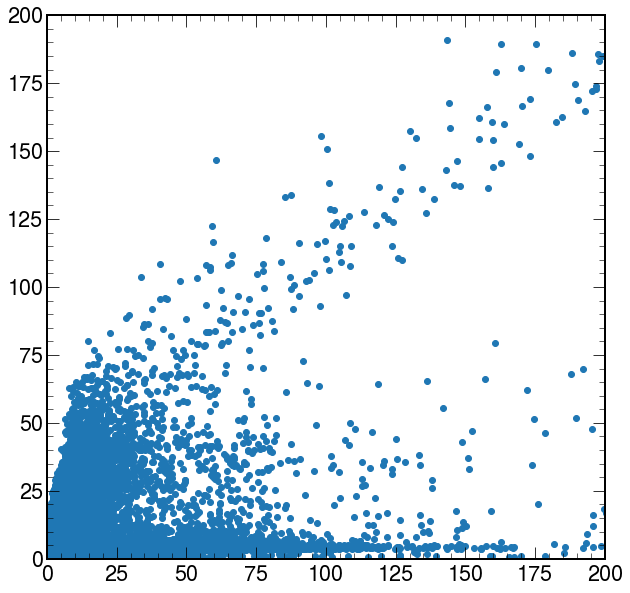

In [192]:
plt.scatter(BB1[:100000,0],BB1[:100000,1])
plt.xlim([0,200])
plt.ylim([0,200])

In [193]:
len(BB1[:,0])

914617

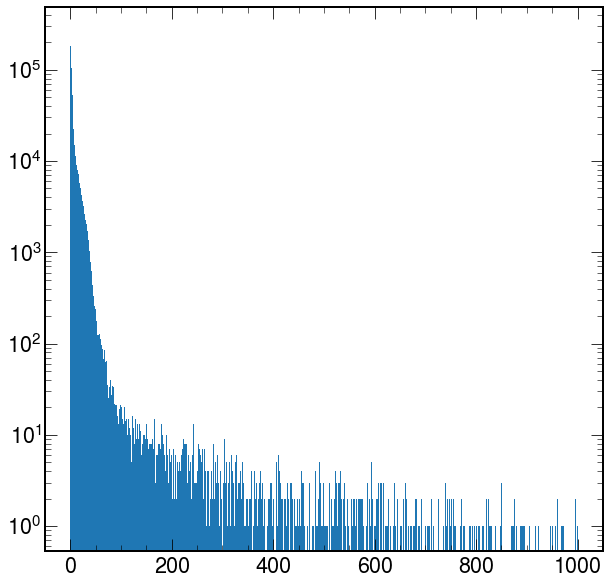

In [194]:
plt.hist(BB1[:,1],bins=np.linspace(0,1000,1000));
#plt.xscale('log')
plt.yscale('log')

# BLACK BOX 1

In [195]:
#bb1_index = np.where((BB1[:,0]>23) & (BB1[:,1]<1.5) & ((dt[:,13]>0.9)) & ((dt[:,0]>4000)) )[0]
#bb1_index = np.where((BB1[:,0]>15) & (BB1[:,1]<1.0)   & ((dt[:,0]<5000)) & ((dt[:,0]>3500)))[0]


#####BB1 default cut #####
#bb1_index = np.where((BB1[:,0]>15) & (BB1[:,1]<1.0)  )[0]


##### BB1 with 3 prong prior
#bb1_index = np.where((BB1[:,0]>15) & (BB1[:,2]<.8)  )[0]

### BB1 with both prior

#bb1_index = np.where((BB1[:,0]>15) & (BB1[:,1]<1.0) & (BB1[:,2]<.8)  )[0]

# BLACK BOX 2

In [232]:
###### BB Testing
bb1_index = np.where((BB1[:,0]>15) & (BB1[:,1]<.5)   )[0]
bkg_index = np.where((BKG[:,0]>15) & (BKG[:,1]<.5)   )[0]

In [233]:
#####BB2 2prong prior #####
#bb1_index = np.where((BB1[:,0]>8.6) & (BB1[:,1]<0.5)  )[0]
       # 2prong prior with trimmed mass cuts
#bb1_index = np.where((BB1[:,0]>10) & (BB1[:,1]<1.1) & (bb_j2trim> 200) &(bb_j1trim>600))[0]

#####BB2 3 prong prior
#bb1_index = np.where((BB1[:,0]>10.3) & (BB1[:,2]<.5)  )[0]
     #3prong prior with trimmed mass cuts
#bb1_index = np.where((BB1[:,0]>8) & (BB1[:,2]<1.5)  & (bb_j2trim> 200) &(bb_j1trim>600) )[0]

###### BB2 with both prior
# bb1_index = np.where((BB1[:,0]>16) & (BB1[:,1]<1.3) & (BB1[:,2]<0.8)   )[0]
# bkg_index = np.where((BKG[:,0]>16) & (BKG[:,1]<1.3) & (BKG[:,2]<0.8)   )[0]
#both prior, masstrim
#bb1_index = np.where((BB1[:,0]>12) & (BB1[:,1]<1) & (BB1[:,2]<1) & (bb_j2trim> 200)  )[0]

# Black Box 3

In [234]:
#####BB3 2prong prior #####
#bb1_index = np.where((BB1[:,0]>6) & (BB1[:,1]<.8)  )[0]
       # 2prong prior with trimmed mass cuts
#bb1_index = np.where((BB1[:,0]>6) & (BB1[:,1]<1.1) & (bb_j1trim> 500) &(bb_j2trim>200))[0]

#####BB3 3 prong prior

#bb1_index = np.where((BB1[:,0]>8) & (BB1[:,2]<.6)  )[0]
     #3prong prior with trimmed mass cuts
#bb1_index = np.where((BB1[:,0]>1) & (BB1[:,2]<.6)  & (bb_j1trim> 600) &(bb_j2trim>200) )[0]

###### BB3 with both prior
#bb1_index = np.where((BB1[:,0]>10) & (BB1[:,1]<1.3) & (BB1[:,2]<1.3))[0]
        #allprior with tau cut on jet 1
#bb1_index = np.where((BB1[:,0]>10) & (BB1[:,1]<1.3) & (BB1[:,2]<1.3) & (dt[:,5]>0.4) )[0]

In [235]:
#bb1_index = np.where((BB1[:,0]>4.) & ((dt[:,13]>0.6)))[0]

In [236]:
print(len(bb1_index),len(bkg_index))

453 163


In [237]:
BBTYPE = 'Black Box 1'
#priorusage = '2prongprior'
#priorusage = '2prongprior_withtrimmedmasscutbyeyeball'
#priorusage = '3prongprior'
#priorusage = '3prongprior_withtrimmedmasscutbyeyeball_j1200j2600'
#priorusage = 'allprior'
priorusage = 'TEST'
BBTYPE_FILENAME = 'BB1'
savedir = 'plots'

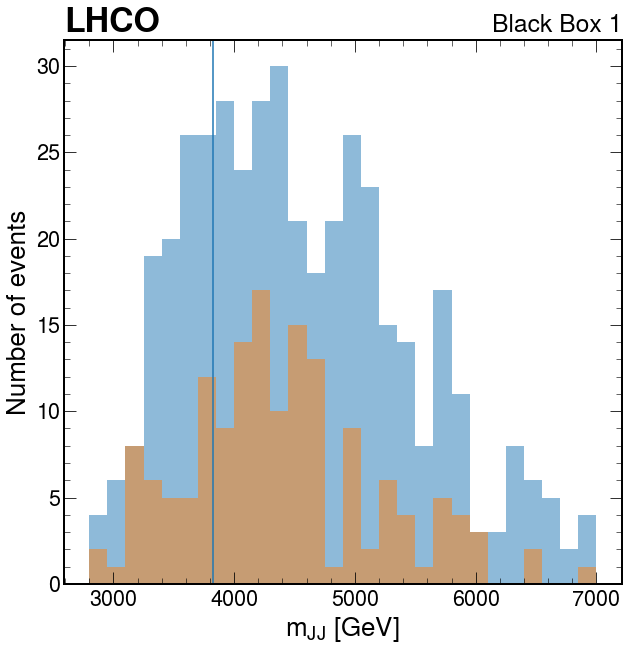

In [239]:
plt.hist(bb_mass[bb1_index],bins=np.linspace(2800,7000,29),alpha=0.5)
plt.hist(bkg_mass[bkg_index],bins=np.linspace(2800,7000,29),alpha=0.5)

plt.axvline(x=3823)
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
#plt.title('subplot 1')
#hep.cms.cmslabel(data=False, paper=False, year='2017')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
#plt.legend(loc='upper right')
#plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_MJJ.png')
#print(a)

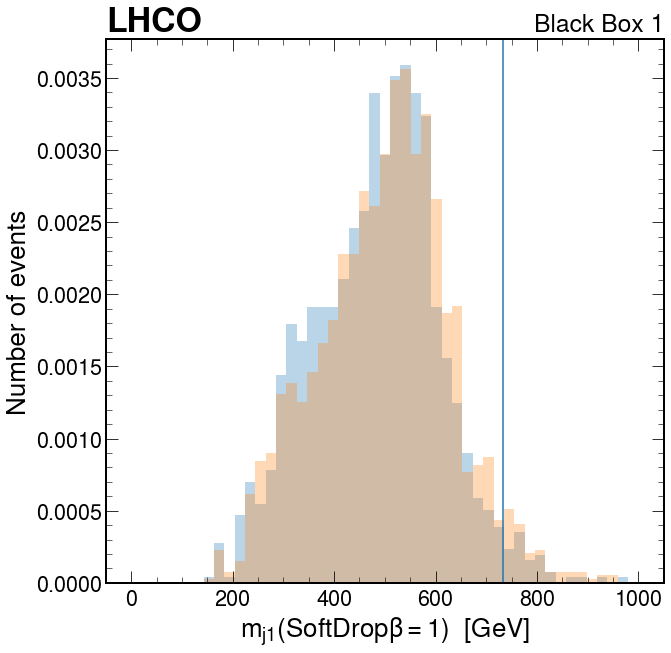

In [177]:
plt.hist(bb_j1sdb1[bb1_index],bins=np.linspace(0,1000,50),density=True,alpha=0.3)
plt.hist(bkg_j1sdb1[bkg_index],bins=np.linspace(0,1000,50),density=True,alpha=0.3)

plt.xlabel(r'$m_{j1}(SoftDrop \beta=1)$  [GeV]')
plt.ylabel('Number of events')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.axvline(x=732)
#plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j1trimmed.png')


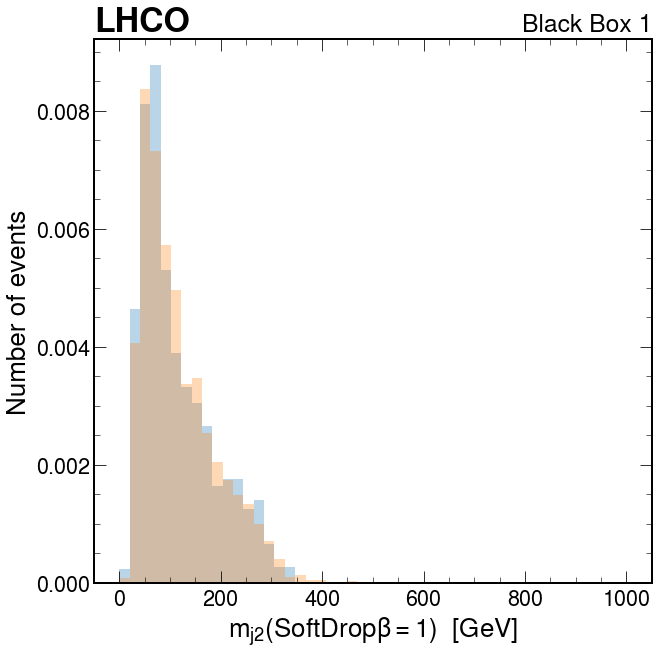

In [178]:
plt.hist(bb_j2sdb1[bb1_index],bins=np.linspace(0,1000,50),density=True,alpha=0.3)
plt.hist(bkg_j2sdb1[bkg_index],bins=np.linspace(0,1000,50),density=True,alpha=0.3)

plt.xlabel(r'$m_{j2}(SoftDrop \beta=1)$  [GeV]')
plt.ylabel('Number of events')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
#plt.axvline(x=378)
#plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j2trimmed.png')


In [ ]:
plt.hist(dt[bb1_index,4],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Selected Events')
plt.hist(dt[:,4],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Default')
plt.legend(loc='upper right')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.xlabel(r'$jet1\ \tau_{21}$')
plt.ylabel('pdf')
plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j1tau21.png')



In [ ]:
plt.hist(dt[bb1_index,5],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Selected Events')
plt.hist(dt[:,5],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Default')
plt.legend(loc='upper left')

hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.xlabel(r'$jet1\ \tau_{32}$')
plt.ylabel('pdf')
plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j1tau32.png')


In [ ]:
plt.hist(dt[bb1_index,20],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Selected Events')
plt.hist(dt[:,20],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Default')
plt.legend(loc='upper left')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.xlabel(r'$jet2\ \tau_{21}$')
plt.ylabel('pdf')
plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j2tau21.png')

In [ ]:
plt.hist(dt[bb1_index,21],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Selected Events')
plt.hist(dt[:,21],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Default')
plt.legend(loc='upper left')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.xlabel(r'$jet2\ \tau_{32}$')
plt.ylabel('pdf')
plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j2tau32.png')

In [ ]:
from scipy.stats import percentileofscore

In [ ]:
percentiles = [percentileofscore(BB1[:,2], i) for i in BB1[:,2]]

In [ ]:
plt.scatter(BB1[:,0],BB1_prob[:,1])
plt.xscale('log')

In [ ]:
def get_loss(X):
    